In [1]:
import tensorflow as tf
from tensorflow import keras

if tf.test.gpu_device_name()=='':
    print('You do not have GPU access.')
    !nvidia-smi

else:
  print('You have GPU access')
  !nvidia-smi

# from tensorflow.python.client import device_lib 
# device_lib.list_local_devices()

# print the tensorflow version
print('TensorFlow {}; Keras {}'.format(tf.__version__, keras.__version__))
tf.test.gpu_device_name()

You have GPU access
Thu Oct 20 18:48:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.40       Driver Version: 516.40       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P5000       WDDM  | 00000000:91:00.0  On |                  Off |
| 26%   32C    P0    41W / 180W |    919MiB / 16384MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                    

'/device:GPU:0'

This network is trained as V4, the input data is scrutinized for empty patches and the junction regions are added to the training data. Testing data is partially unique. Hybrid loss has bee tweaked. Fun to see how this compares to 3-frame.

In [2]:
from tensorflow.keras import layers
import os
import tifffile as tiff
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
from tensorflow import keras


def patch_image(img, SIZE=288):
    #breaks up image to SIZExSIZE non-overlapping patches, returns reshaped array
    # img.shape = (2304, 2304)
    patches = patchify(img, patch_size=(SIZE, SIZE), step=(SIZE, SIZE))
    #patches.shape = (8, 8, 288, 288)

    #return.shape = (64, 288 ,288)
    return patches.reshape(patches.shape[0]*patches.shape[1], SIZE, SIZE, 1)

def patch_stack(img, SIZE=288, DEPTH=3, STRIDE=1):
    # breaks up image to SIZExSIZE non-overlapping patches, returns reshaped array
    # img.shape = (12, 2304, 2304)
    patches = patchify(img, patch_size=(DEPTH, SIZE, SIZE), step=(STRIDE, SIZE, SIZE))
    # patches.shape = (10, 8, 8, 3, 288, 288)

    # return.shape = (64, 3, 288 ,288)
    return patches.reshape(patches.shape[0] * patches.shape[1] * patches.shape[2], -1,  SIZE, SIZE)


# Normalization functions from Martin Weigert
def normalizePercentile(x, pmin=1, pmax=99.8, axis=None, clip=False, eps=1e-20, dtype=np.float32):
    """This function is adapted from Martin Weigert"""
    """Percentile-based image normalization."""

    mi = np.percentile(x, pmin, axis=axis, keepdims=True)
    ma = np.percentile(x, pmax, axis=axis, keepdims=True)
    return normalize_mi_ma(x, mi, ma, clip=clip, eps=eps, dtype=dtype)


def normalize_mi_ma(x, mi, ma, clip=False, eps=1e-20, dtype=np.float32):  # dtype=np.float32
    """This function is adapted from Martin Weigert"""
    if dtype is not None:
        x = x.astype(dtype, copy=False)
        mi = dtype(mi) if np.isscalar(mi) else mi.astype(dtype, copy=False)
        ma = dtype(ma) if np.isscalar(ma) else ma.astype(dtype, copy=False)
        eps = dtype(eps)

    try:
        import numexpr
        x = numexpr.evaluate("(x - mi) / ( ma - mi + eps )")
    except ImportError:
        x = (x - mi) / (ma - mi + eps)

    if clip:
        x = np.clip(x, 0, 1)

    return x


# Simple normalization to min/max fir the Mask
def normalizeMinMax(x, dtype=np.float32):
    x = x.astype(dtype, copy=False)
    x = (x - np.amin(x)) / (np.amax(x) - np.amin(x))
    return x

def checkEmptyMask(arr):
    #checks if any patches are without masks
    #returns list of indexes where mask is all zeros
    out = []
    for i in range(arr.shape[0]):
        if not arr[i].any():
            out.append(i)

    return out


In [3]:
def get_model_memory_usage(batch_size, model):
    import numpy as np
    try:
        from keras import backend as K
    except:
        from tensorflow.keras import backend as K

    shapes_mem_count = 0
    internal_model_mem_count = 0
    for l in model.layers:
        layer_type = l.__class__.__name__
        if layer_type == 'Model':
            internal_model_mem_count += get_model_memory_usage(batch_size, l)
        single_layer_mem = 1
        out_shape = l.output_shape
        if type(out_shape) is list:
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in model.trainable_weights])
    non_trainable_count = np.sum([K.count_params(p) for p in model.non_trainable_weights])

    number_size = 4.0
    if K.floatx() == 'float16':
        number_size = 2.0
    if K.floatx() == 'float64':
        number_size = 8.0

    total_memory = number_size * (batch_size * shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3) + internal_model_mem_count
    return gbytes

In [4]:
train_path = r"Bactnet/Training data/stacks"

batch_size = 16
SIZE = 288
image_dataset = None
mask_dataset = None

def prepare_data(train_path, PATCH_SIZE, delete_empty=False, validation=False, seam=False):
    if validation:
        prefix = "validation"
    else:
        prefix = "training"
    
    stacks = os.listdir(os.path.join(train_path, prefix+"_source"))
    image_dataset = None
    mask_dataset = None
    for stack in stacks:
        if (stack.split(".")[-1]=="tif"):
            img = tiff.imread(os.path.join(train_path, prefix+"_source",stack))
            mask = tiff.imread(os.path.join(train_path, prefix+"_target", stack))
            
            if seam: #should the eges be cropped?
                half = int(PATCH_SIZE/2)
                img = patch_stack(img[1:-1, half:-half, half:-half], PATCH_SIZE, DEPTH = 1)
                mask =patch_stack(mask[: , half:-half, half:-half], PATCH_SIZE, DEPTH = 1)
            else:
                img = patch_stack(img[1:-1], PATCH_SIZE, DEPTH = 1)
                mask =patch_stack(mask, PATCH_SIZE, DEPTH = 1)
            
            print(stack, img.shape, mask.shape)
            mask = normalizeMinMax(mask)
            img = normalizePercentile(img, 0.1, 99.9, clip=True)
            
            if delete_empty:
                not_ok_idxs = checkEmptyMask(mask)
                mask = np.delete(mask, not_ok_idxs, axis=0)
                img = np.delete(img, not_ok_idxs, axis=0)
                print(stack, img.shape, mask.shape)

            

            if image_dataset is not None:
                image_dataset = np.concatenate((image_dataset, img))

            if mask_dataset is not None:
                mask_dataset = np.concatenate((mask_dataset, mask))

            if image_dataset is None:
                image_dataset = img

            if mask_dataset is None:
                mask_dataset = mask

           #print(image_dataset.shape, mask_dataset.shape)

    return image_dataset, mask_dataset




In [5]:
image_dataset, mask_dataset = prepare_data(train_path, SIZE, delete_empty=True, validation=False, seam=False)
seam_data = prepare_data(train_path, SIZE, delete_empty=True, validation=False, seam=False)
X_train = np.concatenate((image_dataset, seam_data[0]))
y_train = np.concatenate((mask_dataset, seam_data[1]))

#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.15, random_state = 8)
X_test, y_test = prepare_data(train_path, SIZE, delete_empty=True, validation=True, seam=False)



print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

BT0398_210.tif (704, 1, 288, 288) (704, 1, 288, 288)
BT0398_210.tif (513, 1, 288, 288) (513, 1, 288, 288)
BT402_169.tif (192, 1, 288, 288) (192, 1, 288, 288)
BT402_169.tif (174, 1, 288, 288) (174, 1, 288, 288)
BT403_002.tif (704, 1, 288, 288) (704, 1, 288, 288)
BT403_002.tif (490, 1, 288, 288) (490, 1, 288, 288)
BT404_199.tif (192, 1, 288, 288) (192, 1, 288, 288)
BT404_199.tif (134, 1, 288, 288) (134, 1, 288, 288)
BT0398_210.tif (704, 1, 288, 288) (704, 1, 288, 288)
BT0398_210.tif (513, 1, 288, 288) (513, 1, 288, 288)
BT402_169.tif (192, 1, 288, 288) (192, 1, 288, 288)
BT402_169.tif (174, 1, 288, 288) (174, 1, 288, 288)
BT403_002.tif (704, 1, 288, 288) (704, 1, 288, 288)
BT403_002.tif (490, 1, 288, 288) (490, 1, 288, 288)
BT404_199.tif (192, 1, 288, 288) (192, 1, 288, 288)
BT404_199.tif (134, 1, 288, 288) (134, 1, 288, 288)
BT0403_229.tif (704, 1, 288, 288) (704, 1, 288, 288)
BT0403_229.tif (364, 1, 288, 288) (364, 1, 288, 288)
BT0407_110.tif (320, 1, 288, 288) (320, 1, 288, 288)
BT040

2152


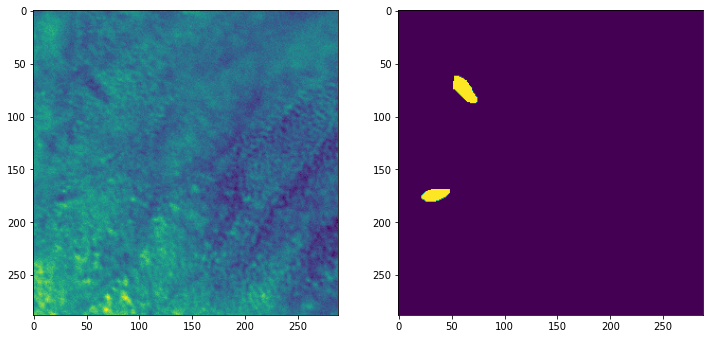

In [6]:
#Sanity check, view few mages
import random

image_number = random.randint(0, X_train.shape[0])
print(image_number)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number, 0, :, :])
plt.subplot(122)
plt.imshow(y_train[image_number, 0, :, :])
plt.show()

###############################################################

In [7]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    t = Conv2D(num_filters, 3, padding="same",  data_format="channels_first", activation='relu')(input)
    t = BatchNormalization()(t)
    t = Dropout(0.1)(t)
    t = Conv2D(num_filters, 3, padding="same",  data_format="channels_first", activation='relu')(t)
    t = BatchNormalization()(t)
    t = Dropout(0.1)(t)
    return t

#Encoder block: Conv block followed by maxpooling

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2), data_format="channels_first")(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same", data_format="channels_first")(input)
    x = Concatenate(axis=1)([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid", data_format="channels_first")(d4)  #Binary (can be multiclass)

    model = Model(inputs, outputs, name="BactUnet_single_frame_training")
    return model

In [8]:
keras.backend.clear_session() # Free up RAM in case the model definition cells were run multiple times


#from keras_unet_collection import models
from keras_unet_collection import losses


# Build model
def hybrid_loss(y_true, y_pred):

    loss_focal = losses.focal_tversky(y_true, y_pred, alpha=0.3, gamma=4/3)
    loss_iou = losses.iou_seg(y_true, y_pred)
    
    # (x) 
    #loss_ssim = losses.ms_ssim(y_true, y_pred, max_val=1.0, filter_size=4)
    
    return loss_focal+loss_iou #+loss_ssim

SIZE=288
input_shape = (1, SIZE, SIZE)
batch_size = 8

model = build_unet(input_shape)
model.compile(loss=hybrid_loss,
            #loss_weights=[0.25, 0.25, 0.25, 0.25, 1.0],
                optimizer=keras.optimizers.Adam(learning_rate=1e-4), metrics=[losses.dice_coef, losses.iou_seg])
model.summary()
print(get_model_memory_usage(batch_size, model))


Model: "BactUnet_single_frame_training"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1, 288, 288) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 288, 288) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 288, 288) 1152        conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 64, 288, 288) 0           batch_normalization[0][0]        
_____________________________________________________________________

(8, 1, 288, 288) (8, 1, 288, 288)


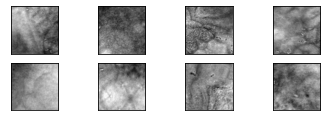

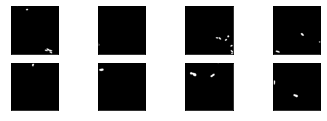

In [9]:
#New generator with rotation and shear where interpolation that comes with rotation and shear are thresholded in masks. 
#This gives a binary mask rather than a mask with interpolated values. 
seed=1337
from keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rotation_range=180,
                     width_shift_range=0.25,
                     height_shift_range=0.25,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',
                     data_format="channels_first")

mask_data_gen_args = dict(rotation_range=180,
                     width_shift_range=0.25,
                     height_shift_range=0.25,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',
                     data_format="channels_first",
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again. 

image_data_generator = ImageDataGenerator(**img_data_gen_args)
#image_data_generator.fit(X_train, augment=True, seed=seed)

image_generator = image_data_generator.flow(X_train, seed=seed, batch_size=batch_size)
valid_img_generator = image_data_generator.flow(X_test, seed=seed, batch_size=batch_size) #Default batch size 32, if not specified here

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
#mask_data_generator.fit(y_train, augment=True, seed=seed)
mask_generator = mask_data_generator.flow(y_train, seed=seed, batch_size=batch_size)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed, batch_size=batch_size)  #Default batch size 32, if not specified here

def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)


x = valid_img_generator.next()
y = valid_mask_generator.next()
print(x.shape, y.shape)
for i in range(len(x)):
    image = x[i]
    fig1 = plt.subplot(4, 4, i+1)
    fig1.set_xticks([])  #Turn off axis
    fig1.set_yticks([])
    plt.imshow(image[0, :,:], cmap='gray')
    #plt.subplot(4,4,2)
    #plt.imshow(mask[0,:,:])
plt.show()

for i in range(len(x)):
    image = y[i]
    fig1 = plt.subplot(4, 4, i+1)
    fig1.set_xticks([])  #Turn off axis
    fig1.set_yticks([])
    plt.imshow(image[0, :,:], cmap='gray')
    #plt.subplot(4,4,2)
    #plt.imshow(mask[0,:,:])
plt.show()


steps_per_epoch = 3*(len(X_train))//batch_size

In [13]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

epochs = 100
#model.load_weights(r"/models/bactunet_3frame_local.hdf5")
model_name = "bactunet_V4_single_frame"
#ModelCheckpoint callback saves a model at some interval.

filepath=r"models/"+model_name+".hdf5"
#Use Mode = max for accuracy and min for loss. 
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=100, verbose=1)
#This callback will stop the training when there is no improvement in
# the validation loss for 10 consecutive epochs.

#CSVLogger logs epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger(r'models/'+model_name+'.csv', separator=',', append=False)

callbacks_list = [checkpoint, early_stop, log_csv]

#We can now use these generators to train our model. 
#Give this a name so we can call it later for plotting loss, accuracy etc. as a function of epochs.

history = model.fit(
        my_generator,
        steps_per_epoch=steps_per_epoch,   
        epochs=epochs,
        validation_data=validation_datagen,
        validation_steps=steps_per_epoch,
        callbacks=callbacks_list)

model.save(r"models/"+model_name+".hdf5") 

Epoch 1/100
983/983 [==============================] - 765s 778ms/step - loss: 1.3887 - dice_coef: 0.4056 - iou_seg: 0.7346 - val_loss: 1.3111 - val_dice_coef: 0.4822 - val_iou_seg: 0.6741

Epoch 00001: val_loss improved from inf to 1.31109, saving model to models\bactunet_V4_single_frame.hdf5
Epoch 2/100
983/983 [==============================] - 759s 772ms/step - loss: 1.1698 - dice_coef: 0.5308 - iou_seg: 0.6321 - val_loss: 1.2325 - val_dice_coef: 0.5272 - val_iou_seg: 0.6345

Epoch 00002: val_loss improved from 1.31109 to 1.23248, saving model to models\bactunet_V4_single_frame.hdf5
Epoch 3/100
983/983 [==============================] - 755s 768ms/step - loss: 1.1116 - dice_coef: 0.5629 - iou_seg: 0.6018 - val_loss: 1.1917 - val_dice_coef: 0.5476 - val_iou_seg: 0.6149

Epoch 00003: val_loss improved from 1.23248 to 1.19172, saving model to models\bactunet_V4_single_frame.hdf5
Epoch 4/100
983/983 [==============================] - 755s 769ms/step - loss: 1.0883 - dice_coef: 0.5727 -


Epoch 00032: val_loss did not improve from 1.01585
Epoch 33/100
983/983 [==============================] - 755s 769ms/step - loss: 0.9175 - dice_coef: 0.6601 - iou_seg: 0.5014 - val_loss: 1.0910 - val_dice_coef: 0.5899 - val_iou_seg: 0.5716

Epoch 00033: val_loss did not improve from 1.01585
Epoch 34/100
983/983 [==============================] - 755s 768ms/step - loss: 0.9118 - dice_coef: 0.6613 - iou_seg: 0.5000 - val_loss: 1.1153 - val_dice_coef: 0.5895 - val_iou_seg: 0.5742

Epoch 00034: val_loss did not improve from 1.01585
Epoch 35/100
983/983 [==============================] - 754s 767ms/step - loss: 0.9137 - dice_coef: 0.6603 - iou_seg: 0.5009 - val_loss: 1.0483 - val_dice_coef: 0.5970 - val_iou_seg: 0.5649

Epoch 00035: val_loss did not improve from 1.01585
Epoch 36/100
983/983 [==============================] - 755s 768ms/step - loss: 0.9173 - dice_coef: 0.6592 - iou_seg: 0.5022 - val_loss: 1.1132 - val_dice_coef: 0.5820 - val_iou_seg: 0.5806

Epoch 00036: val_loss did not i

983/983 [==============================] - 756s 769ms/step - loss: 0.8099 - dice_coef: 0.7097 - iou_seg: 0.4445 - val_loss: 1.0295 - val_dice_coef: 0.6230 - val_iou_seg: 0.5394

Epoch 00099: val_loss did not improve from 0.98052
Epoch 100/100
983/983 [==============================] - 757s 770ms/step - loss: 0.8175 - dice_coef: 0.7066 - iou_seg: 0.4487 - val_loss: 1.0057 - val_dice_coef: 0.6304 - val_iou_seg: 0.5305

Epoch 00100: val_loss did not improve from 0.98052


In [ ]:
model.save(r"models/"+model_name+".hdf5") 
#model.load_weights(r"models/bactunet_3frame_local_dice.hdf5")

In [85]:
#Continue training 


#Use Mode = max for accuracy and min for loss. 
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=100, verbose=1)
#This callback will stop the training when there is no improvement in
# the validation loss for 10 consecutive epochs.

#CSVLogger logs epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger(r'models/bactnet_v3_logs.csv', separator=',', append=False)

callbacks_list = [checkpoint, early_stop, log_csv]

#We can now use these generators to train our model. 
#Give this a name so we can call it later for plotting loss, accuracy etc. as a function of epochs.

history = model.fit(
        my_generator,
        steps_per_epoch=steps_per_epoch,   
        epochs=1000,
        validation_data=validation_datagen,
        validation_steps=steps_per_epoch,
        callbacks=callbacks_list)

model.save(r"models/bactunet_noEmpty_final_alldata.hdf5") 

Epoch 1/1000
377/377 [==============================] - 535s 1s/step - loss: 0.2166 - dice_coef: 0.6960 - iou_seg: 0.4598 - val_loss: 0.2169 - val_dice_coef: 0.6917 - val_iou_seg: 0.4629

Epoch 00001: val_loss improved from inf to 0.21688, saving model to models\bactunet_3frame_dice_noEmpty_alldata.hdf5
Epoch 2/1000
377/377 [==============================] - 518s 1s/step - loss: 0.2152 - dice_coef: 0.6982 - iou_seg: 0.4567 - val_loss: 0.2189 - val_dice_coef: 0.6885 - val_iou_seg: 0.4663

Epoch 00002: val_loss did not improve from 0.21688
Epoch 3/1000
377/377 [==============================] - 513s 1s/step - loss: 0.2147 - dice_coef: 0.6994 - iou_seg: 0.4560 - val_loss: 0.2222 - val_dice_coef: 0.6846 - val_iou_seg: 0.4723

Epoch 00003: val_loss did not improve from 0.21688
Epoch 4/1000
377/377 [==============================] - 513s 1s/step - loss: 0.2139 - dice_coef: 0.7004 - iou_seg: 0.4537 - val_loss: 0.2167 - val_dice_coef: 0.6957 - val_iou_seg: 0.4587

Epoch 00004: val_loss improve

377/377 [==============================] - 511s 1s/step - loss: 0.1859 - dice_coef: 0.7518 - iou_seg: 0.3938 - val_loss: 0.2431 - val_dice_coef: 0.6465 - val_iou_seg: 0.5165

Epoch 00068: val_loss did not improve from 0.21384
Epoch 69/1000
377/377 [==============================] - 508s 1s/step - loss: 0.1826 - dice_coef: 0.7576 - iou_seg: 0.3866 - val_loss: 0.2234 - val_dice_coef: 0.6812 - val_iou_seg: 0.4764

Epoch 00069: val_loss did not improve from 0.21384
Epoch 70/1000
377/377 [==============================] - 511s 1s/step - loss: 0.1848 - dice_coef: 0.7536 - iou_seg: 0.3916 - val_loss: 0.2475 - val_dice_coef: 0.6357 - val_iou_seg: 0.5264

Epoch 00070: val_loss did not improve from 0.21384
Epoch 71/1000
377/377 [==============================] - 508s 1s/step - loss: 0.1839 - dice_coef: 0.7552 - iou_seg: 0.3893 - val_loss: 0.2149 - val_dice_coef: 0.6991 - val_iou_seg: 0.4572

Epoch 00071: val_loss did not improve from 0.21384
Epoch 72/1000
377/377 [==============================]


Epoch 00134: val_loss did not improve from 0.20570
Epoch 135/1000
377/377 [==============================] - 510s 1s/step - loss: 0.1686 - dice_coef: 0.7810 - iou_seg: 0.3560 - val_loss: 0.2128 - val_dice_coef: 0.7010 - val_iou_seg: 0.4533

Epoch 00135: val_loss did not improve from 0.20570
Epoch 136/1000
377/377 [==============================] - 510s 1s/step - loss: 0.1746 - dice_coef: 0.7713 - iou_seg: 0.3690 - val_loss: 0.2185 - val_dice_coef: 0.6905 - val_iou_seg: 0.4661

Epoch 00136: val_loss did not improve from 0.20570
Epoch 137/1000
377/377 [==============================] - 508s 1s/step - loss: 0.1725 - dice_coef: 0.7751 - iou_seg: 0.3647 - val_loss: 0.2297 - val_dice_coef: 0.6721 - val_iou_seg: 0.4879

Epoch 00137: val_loss did not improve from 0.20570
Epoch 138/1000
377/377 [==============================] - 511s 1s/step - loss: 0.1679 - dice_coef: 0.7824 - iou_seg: 0.3544 - val_loss: 0.2245 - val_dice_coef: 0.6798 - val_iou_seg: 0.4791

Epoch 00138: val_loss did not impro


Epoch 00168: val_loss did not improve from 0.20570
Epoch 169/1000
377/377 [==============================] - 510s 1s/step - loss: 0.1643 - dice_coef: 0.7885 - iou_seg: 0.3467 - val_loss: 0.2258 - val_dice_coef: 0.6761 - val_iou_seg: 0.4815

Epoch 00169: val_loss did not improve from 0.20570
Epoch 170/1000
377/377 [==============================] - 510s 1s/step - loss: 0.1648 - dice_coef: 0.7877 - iou_seg: 0.3479 - val_loss: 0.2243 - val_dice_coef: 0.6799 - val_iou_seg: 0.4786

Epoch 00170: val_loss did not improve from 0.20570
Epoch 171/1000
377/377 [==============================] - 509s 1s/step - loss: 0.1647 - dice_coef: 0.7875 - iou_seg: 0.3476 - val_loss: 0.2306 - val_dice_coef: 0.6656 - val_iou_seg: 0.4937

Epoch 00171: val_loss did not improve from 0.20570
Epoch 172/1000
377/377 [==============================] - 510s 1s/step - loss: 0.1642 - dice_coef: 0.7883 - iou_seg: 0.3463 - val_loss: 0.2140 - val_dice_coef: 0.7010 - val_iou_seg: 0.4543

Epoch 00172: val_loss did not impro


Epoch 00202: val_loss did not improve from 0.20570
Epoch 203/1000
377/377 [==============================] - 509s 1s/step - loss: 0.1592 - dice_coef: 0.7969 - iou_seg: 0.3354 - val_loss: 0.2282 - val_dice_coef: 0.6717 - val_iou_seg: 0.4863

Epoch 00203: val_loss did not improve from 0.20570
Epoch 00203: early stopping


IoU socre is:  0.004 Dice coeff is:  0 at threshold:  0.0
IoU socre is:  0.5224 Dice coeff is:  0 at threshold:  0.1
IoU socre is:  0.5227 Dice coeff is:  0 at threshold:  0.2
IoU socre is:  0.5229 Dice coeff is:  0 at threshold:  0.3
IoU socre is:  0.5229 Dice coeff is:  0 at threshold:  0.4
IoU socre is:  0.523 Dice coeff is:  0 at threshold:  0.5
IoU socre is:  0.5231 Dice coeff is:  0 at threshold:  0.6
IoU socre is:  0.5232 Dice coeff is:  0 at threshold:  0.7
IoU socre is:  0.5234 Dice coeff is:  0 at threshold:  0.8
IoU socre is:  0.5237 Dice coeff is:  0 at threshold:  0.9
IoU socre is:  0.0 Dice coeff is:  0 at threshold:  1.0


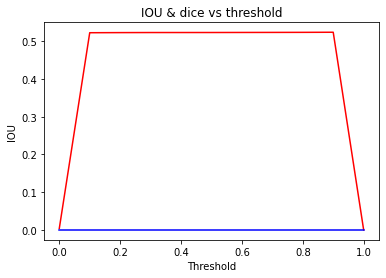

In [86]:
# ##################################
# #IOU
y_pred = model.predict(X_test)
IOUs = []
dices = []
thresh = []

for threshold in range(0, 11):
  threshold = threshold/10
  y_pred_thresholded = y_pred > threshold
  intersection = np.logical_and(y_test, y_pred_thresholded)
  union = np.logical_or(y_test, y_pred_thresholded)
  iou_score = np.sum(intersection) / np.sum(union)
  dice_c = 0#losses.dice_coef(y_test, y_pred)
  print("IoU socre is: ", round(iou_score, 4), "Dice coeff is: ", round(dice_c, 4),"at threshold: ", threshold)
  IOUs.append(iou_score)
  thresh.append(threshold)
  dices.append(dice_c)

#plot IOUs vs threshold
plt.plot(thresh, IOUs, 'r', label='IOU')
plt.plot(thresh, dices, 'b', label='Dice coeff')
plt.title('IOU & dice vs threshold')
plt.xlabel('Threshold')
plt.ylabel('IOU')
plt.show()

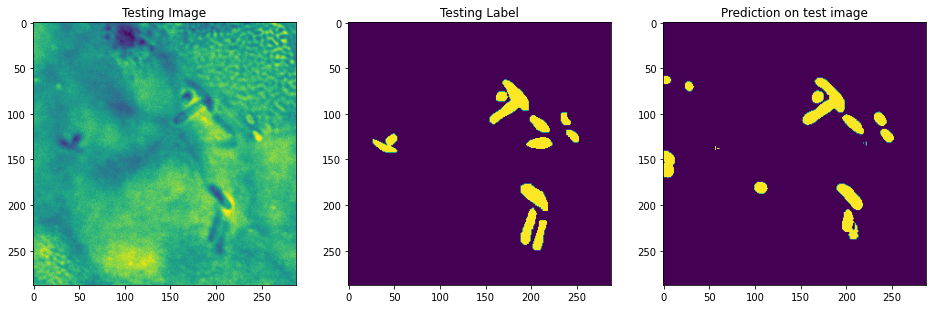

In [87]:
#######################################################################
#Predict on a few images
#model = get_model()
#model.load_weights('mitochondria_50_plus_100_epochs.hdf5') #Trained for 50 epochs and then additional 100
#model.load_weights('mitochondria_gpu_tf1.4.hdf5')  #Trained for 50 epochs¨
#import pickle
#with open("/content/gdrive/MyDrive/Colab Notebooks/BT0403/model_folder/bactunet_3frame_25ep_history") as fh:
#    history = pickle.load(fh)

idx=random.randint(0, (len(X_test)))

plt.figure(figsize=(16, 8))
plt.subplot(131)
plt.title('Testing Image')
plt.imshow(X_test[idx, 1, :, : ])
plt.subplot(132)
plt.title('Testing Label')
plt.imshow(y_test[idx, 0, : , :])
plt.subplot(133)
plt.title('Prediction on test image')
plt.imshow(y_pred[idx, 0, :, :])

plt.show()

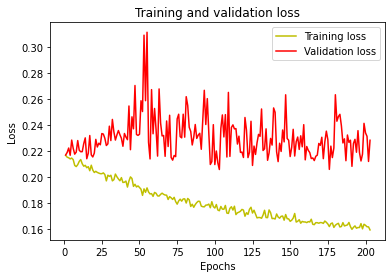

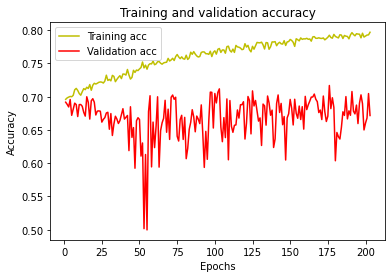

In [88]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['dice_coef']
#acc = history.history['accuracy']
val_acc = history.history['val_dice_coef']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [89]:
import math 
from patchify import unpatchify

#######
#THERE IS A BUG HERE!!! FIX PREDICTION AND UNPATCHING


def _createOutArr(shape, nrows, ncols, nchannels):
    out_height = int(nrows * shape[-2])
    out_width = int(ncols * shape[-1])
    out_frames = int(shape[0] / (nrows * ncols))
    outshape = (out_frames, nchannels, out_height, out_width)
    out_arr = np.empty(outshape, dtype=np.float32)

    return out_arr

def unpatcher(arr, nrows, ncols, nchannels=1):
    out_arr = _createOutArr(arr.shape, nrows, ncols, nchannels)
    patch_h = arr.shape[-2]
    patch_w = arr.shape[-1]
    n = 0
    for frame in range(out_arr.shape[0]):
        for i in range(nrows):
            for j in range(ncols):
                y = patch_h * i
                x = patch_w * j
                out_arr[frame, :, y:y+patch_h, x:x+patch_w] = arr[n]
                n += 1

    return out_arr

#load unseen data

validation_image_directory = r"C:\Users\analyst\Documents\Python Scripts\BactUnet\Bactnet\Training data\stacks\predict"
result_folder = r"C:\Users\analyst\Documents\Python Scripts\BactUnet\_results"

val_image_dataset = []
val_mask_dataset = []
pred_mask_dataset = []

images = os.listdir(validation_image_directory)

for i, image_name in enumerate(images):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'tif'):
        
        image = tiff.imread(os.path.join(validation_image_directory, image_name))
        original_shape = image.shape
        patch = patch_stack(image, SIZE)
        
        patch = normalizePercentile(patch, 0.1, 99.9, clip=True)
        pred_mask_patch = model.predict(patch)
        print(image_name, original_shape, patch.shape, pred_mask_patch.shape)
        #pred_mask_patch = pred_mask_patch[:, 0, :,:]
        image = np.expand_dims(patch[:, 1, :,:], axis=1)
        patch = np.concatenate((image, pred_mask_patch), axis=1)
        unpatched = unpatcher(patch, 8, 8, 2)
        print(patch.shape)
        tiff.imwrite(os.path.join(result_folder, image_name), unpatched, imagej=True, resolution=(1./2.6755, 1./2.6755),
                      metadata={'unit': 'um', 'finterval': 15,
                                'axes': 'TCYX'})
        
        #pred_mask = unpatch_stack(pred_mask_patch, original_shape)
        #tiff.imsave(os.path.join(result_folder, image_name), pred_mask_patch)
        #val_image_dataset.append(image)
        #pred_mask_dataset.append(pred_mask)

BT0398_210.tif (11, 2304, 2304) (576, 3, 288, 288) (576, 1, 288, 288)
(576, 2, 288, 288)
BT403_013.tif (12, 2304, 2304) (640, 3, 288, 288) (640, 1, 288, 288)
(640, 2, 288, 288)
BT403_216.tif (12, 2304, 2304) (640, 3, 288, 288) (640, 1, 288, 288)
(640, 2, 288, 288)
BT404_001.tif (12, 2304, 2304) (640, 3, 288, 288) (640, 1, 288, 288)
(640, 2, 288, 288)


In [90]:
#Let's try the full movies

image_directory = r"C:\Users\analyst\Documents\Python Scripts\BactUnet\Bactnet"
result_folder = r"C:\Users\analyst\Documents\Python Scripts\BactUnet\_results"
filelist = []

for dir in os.listdir(image_directory):
    for file in os.listdir(os.path.join(image_directory, dir)):
        if ".tif" in file:
            loadme = os.path.join(image_directory, dir, file)
            image = tiff.imread(loadme)
            original_shape = image.shape
            patch = patch_stack(image, SIZE)
            patchlist = np.split(patch, 238)
            
            for i, p in enumerate(patchlist):
                p = normalizePercentile(p, 0.1, 99.9, clip=True)
                pred_mask_patch = model.predict(p)
                unpatched = unpatcher(pred_mask_patch, 8, 8, 1)
                #unpatched = unpatched.astype('uint8')
                savename = file.split(".")[0]+ "_V3_" + str(i+1) + ".tif"
                print(savename, unpatched.shape)
                tiff.imwrite(os.path.join(result_folder, savename), unpatched, imagej=True, resolution=(1./2.6755, 1./2.6755),
                             metadata={'unit': 'um', 'finterval': 15, 'axes': 'TCYX'})


BT0398_OGM_V3_1.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_2.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_3.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_4.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_5.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_6.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_7.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_8.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_9.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_10.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_11.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_12.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_13.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_14.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_15.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_16.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_17.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_18.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_19.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_20.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_21.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_22.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_23.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_24.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_25.tif (1, 1, 2304, 2304)
BT0398_OG

BT0398_OGM_V3_204.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_205.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_206.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_207.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_208.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_209.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_210.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_211.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_212.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_213.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_214.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_215.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_216.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_217.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_218.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_219.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_220.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_221.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_222.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_223.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_224.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_225.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_226.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_227.tif (1, 1, 2304, 2304)
BT0398_OGM_V3_22

BT0402_ENR_wt_V3_158.tif (1, 1, 2304, 2304)
BT0402_ENR_wt_V3_159.tif (1, 1, 2304, 2304)
BT0402_ENR_wt_V3_160.tif (1, 1, 2304, 2304)
BT0402_ENR_wt_V3_161.tif (1, 1, 2304, 2304)
BT0402_ENR_wt_V3_162.tif (1, 1, 2304, 2304)
BT0402_ENR_wt_V3_163.tif (1, 1, 2304, 2304)
BT0402_ENR_wt_V3_164.tif (1, 1, 2304, 2304)
BT0402_ENR_wt_V3_165.tif (1, 1, 2304, 2304)
BT0402_ENR_wt_V3_166.tif (1, 1, 2304, 2304)
BT0402_ENR_wt_V3_167.tif (1, 1, 2304, 2304)
BT0402_ENR_wt_V3_168.tif (1, 1, 2304, 2304)
BT0402_ENR_wt_V3_169.tif (1, 1, 2304, 2304)
BT0402_ENR_wt_V3_170.tif (1, 1, 2304, 2304)
BT0402_ENR_wt_V3_171.tif (1, 1, 2304, 2304)
BT0402_ENR_wt_V3_172.tif (1, 1, 2304, 2304)
BT0402_ENR_wt_V3_173.tif (1, 1, 2304, 2304)
BT0402_ENR_wt_V3_174.tif (1, 1, 2304, 2304)
BT0402_ENR_wt_V3_175.tif (1, 1, 2304, 2304)
BT0402_ENR_wt_V3_176.tif (1, 1, 2304, 2304)
BT0402_ENR_wt_V3_177.tif (1, 1, 2304, 2304)
BT0402_ENR_wt_V3_178.tif (1, 1, 2304, 2304)
BT0402_ENR_wt_V3_179.tif (1, 1, 2304, 2304)
BT0402_ENR_wt_V3_180.tif (1, 1, 

BT403_OGM_wt_V3_112.tif (1, 1, 2304, 2304)
BT403_OGM_wt_V3_113.tif (1, 1, 2304, 2304)
BT403_OGM_wt_V3_114.tif (1, 1, 2304, 2304)
BT403_OGM_wt_V3_115.tif (1, 1, 2304, 2304)
BT403_OGM_wt_V3_116.tif (1, 1, 2304, 2304)
BT403_OGM_wt_V3_117.tif (1, 1, 2304, 2304)
BT403_OGM_wt_V3_118.tif (1, 1, 2304, 2304)
BT403_OGM_wt_V3_119.tif (1, 1, 2304, 2304)
BT403_OGM_wt_V3_120.tif (1, 1, 2304, 2304)
BT403_OGM_wt_V3_121.tif (1, 1, 2304, 2304)
BT403_OGM_wt_V3_122.tif (1, 1, 2304, 2304)
BT403_OGM_wt_V3_123.tif (1, 1, 2304, 2304)
BT403_OGM_wt_V3_124.tif (1, 1, 2304, 2304)
BT403_OGM_wt_V3_125.tif (1, 1, 2304, 2304)
BT403_OGM_wt_V3_126.tif (1, 1, 2304, 2304)
BT403_OGM_wt_V3_127.tif (1, 1, 2304, 2304)
BT403_OGM_wt_V3_128.tif (1, 1, 2304, 2304)
BT403_OGM_wt_V3_129.tif (1, 1, 2304, 2304)
BT403_OGM_wt_V3_130.tif (1, 1, 2304, 2304)
BT403_OGM_wt_V3_131.tif (1, 1, 2304, 2304)
BT403_OGM_wt_V3_132.tif (1, 1, 2304, 2304)
BT403_OGM_wt_V3_133.tif (1, 1, 2304, 2304)
BT403_OGM_wt_V3_134.tif (1, 1, 2304, 2304)
BT403_OGM_w

BT404_ENR+RT_wt_V3_62.tif (1, 1, 2304, 2304)
BT404_ENR+RT_wt_V3_63.tif (1, 1, 2304, 2304)
BT404_ENR+RT_wt_V3_64.tif (1, 1, 2304, 2304)
BT404_ENR+RT_wt_V3_65.tif (1, 1, 2304, 2304)
BT404_ENR+RT_wt_V3_66.tif (1, 1, 2304, 2304)
BT404_ENR+RT_wt_V3_67.tif (1, 1, 2304, 2304)
BT404_ENR+RT_wt_V3_68.tif (1, 1, 2304, 2304)
BT404_ENR+RT_wt_V3_69.tif (1, 1, 2304, 2304)
BT404_ENR+RT_wt_V3_70.tif (1, 1, 2304, 2304)
BT404_ENR+RT_wt_V3_71.tif (1, 1, 2304, 2304)
BT404_ENR+RT_wt_V3_72.tif (1, 1, 2304, 2304)
BT404_ENR+RT_wt_V3_73.tif (1, 1, 2304, 2304)
BT404_ENR+RT_wt_V3_74.tif (1, 1, 2304, 2304)
BT404_ENR+RT_wt_V3_75.tif (1, 1, 2304, 2304)
BT404_ENR+RT_wt_V3_76.tif (1, 1, 2304, 2304)
BT404_ENR+RT_wt_V3_77.tif (1, 1, 2304, 2304)
BT404_ENR+RT_wt_V3_78.tif (1, 1, 2304, 2304)
BT404_ENR+RT_wt_V3_79.tif (1, 1, 2304, 2304)
BT404_ENR+RT_wt_V3_80.tif (1, 1, 2304, 2304)
BT404_ENR+RT_wt_V3_81.tif (1, 1, 2304, 2304)
BT404_ENR+RT_wt_V3_82.tif (1, 1, 2304, 2304)
BT404_ENR+RT_wt_V3_83.tif (1, 1, 2304, 2304)
BT404_ENR+

In [48]:


loadme = os.path.join(image_directory, fname)
image = tiff.imread(loadme)
original_shape = image.shape
patch = patch_stack(image, SIZE)
print(original_shape, patch.shape)

#split into smaller predictions
patchlist = np.split(patch, 238)
print(patchlist[0].shape)
for i, p in enumerate(patchlist):
    p = normalizePercentile(p, 0.1, 99.9, clip=True)
    pred_mask_patch = model.predict(p)
    unpatched = unpatcher(pred_mask_patch, 8, 8, 1)
    #unpatched = unpatched.astype('uint8')
    savename = "BT404_" + str(i+1) + ".tif"
    print(savename, unpatched.shape)
    tiff.imwrite(os.path.join(result_folder, savename), unpatched, imagej=True, resolution=(1./2.6755, 1./2.6755),
                 metadata={'unit': 'um', 'finterval': 15, 'axes': 'TCYX'})

(240, 2304, 2304) (15232, 3, 288, 288)
(64, 3, 288, 288)
BT404_1.tif (1, 1, 2304, 2304)
BT404_2.tif (1, 1, 2304, 2304)
BT404_3.tif (1, 1, 2304, 2304)
BT404_4.tif (1, 1, 2304, 2304)
BT404_5.tif (1, 1, 2304, 2304)
BT404_6.tif (1, 1, 2304, 2304)
BT404_7.tif (1, 1, 2304, 2304)
BT404_8.tif (1, 1, 2304, 2304)
BT404_9.tif (1, 1, 2304, 2304)
BT404_10.tif (1, 1, 2304, 2304)
BT404_11.tif (1, 1, 2304, 2304)
BT404_12.tif (1, 1, 2304, 2304)
BT404_13.tif (1, 1, 2304, 2304)
BT404_14.tif (1, 1, 2304, 2304)
BT404_15.tif (1, 1, 2304, 2304)
BT404_16.tif (1, 1, 2304, 2304)
BT404_17.tif (1, 1, 2304, 2304)
BT404_18.tif (1, 1, 2304, 2304)
BT404_19.tif (1, 1, 2304, 2304)
BT404_20.tif (1, 1, 2304, 2304)
BT404_21.tif (1, 1, 2304, 2304)
BT404_22.tif (1, 1, 2304, 2304)
BT404_23.tif (1, 1, 2304, 2304)
BT404_24.tif (1, 1, 2304, 2304)
BT404_25.tif (1, 1, 2304, 2304)
BT404_26.tif (1, 1, 2304, 2304)
BT404_27.tif (1, 1, 2304, 2304)
BT404_28.tif (1, 1, 2304, 2304)
BT404_29.tif (1, 1, 2304, 2304)
BT404_30.tif (1, 1, 2304

1 conv2d (3, 3, 3, 64)
4 conv2d_1 (3, 3, 64, 64)
8 conv2d_2 (3, 3, 64, 128)
11 conv2d_3 (3, 3, 128, 128)
15 conv2d_4 (3, 3, 128, 256)
18 conv2d_5 (3, 3, 256, 256)
22 conv2d_6 (3, 3, 256, 512)
25 conv2d_7 (3, 3, 512, 512)
29 conv2d_8 (3, 3, 512, 1024)
32 conv2d_9 (3, 3, 1024, 1024)
35 conv2d_transpose (2, 2, 512, 1024)
37 conv2d_10 (3, 3, 1024, 512)
40 conv2d_11 (3, 3, 512, 512)
43 conv2d_transpose_1 (2, 2, 256, 512)
45 conv2d_12 (3, 3, 512, 256)
48 conv2d_13 (3, 3, 256, 256)
51 conv2d_transpose_2 (2, 2, 128, 256)
53 conv2d_14 (3, 3, 256, 128)
56 conv2d_15 (3, 3, 128, 128)
59 conv2d_transpose_3 (2, 2, 64, 128)
61 conv2d_16 (3, 3, 128, 64)
64 conv2d_17 (3, 3, 64, 64)
67 conv2d_18 (1, 1, 64, 1)


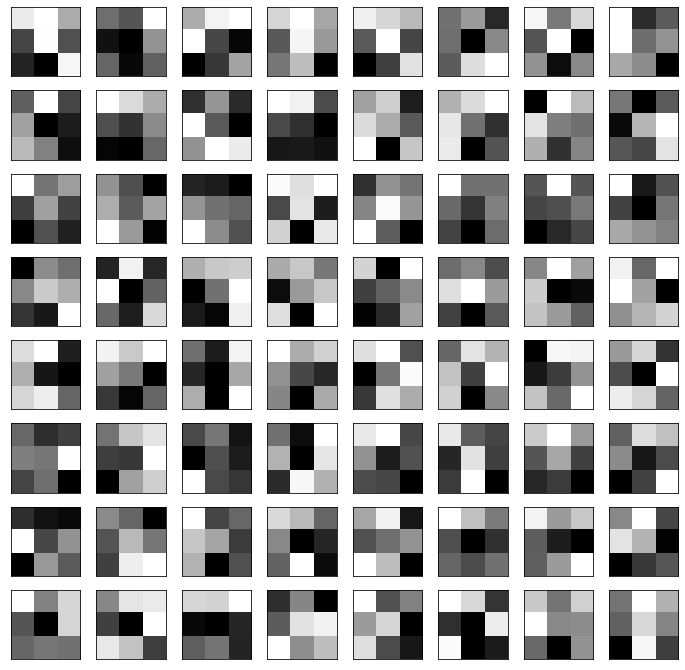

In [27]:
for i, layer in enumerate(model.layers):
  if "onv" in layer.name:
    print(i, layer.name, model.layers[i].get_weights()[0].shape)

weights, biases =  model.layers[4].get_weights()
fig1=plt.figure(figsize=(12, 12))


columns = 8 
rows = 8 
n_filters = columns*rows
for i in range(1, n_filters +1):
    f = weights[:, :, (i-1), 0]
    fig1 =plt.subplot(rows, columns, i)
    fig1.set_xticks([])  #Turn off axis
    fig1.set_yticks([])

    #plt.imshow(f[i%3, :, :], cmap='gray')
    plt.imshow(f[:, :], cmap='gray')
    #plt.imshow(f[2, :, :], cmap='gray') #Show only the filters from 0th channel (R)
    #ix += 1
plt.show() 